# Introduction

This project aims to develop a set of predictive model for monitoring and optimizing water quality in freshwater aquaponics systems dedicated to catfish farming. By leveraging IoT sensor data and machine learning techniques, we analyze key environmental and biological factors influencing water health and fish well-being. Our system integrates real-time data collection from twelve aquaponics ponds, each monitored by an ESP-32 microcontroller equipped with sensors measuring parameters such as turbidity, temperature, ammonia, nitrate, dissolved oxygen, and pH.

The *Sensor Based Aquaponics Fish Pond Datasets*$\text{}^{1}$ consists of time-series records spanning from June to mid-October 2021, collected from twelve aquaponics ponds. Each pond is monitored individually, with IoT units capturing data every five minutes. These measurements provide insights into the complex interactions between water conditions and fish health, enabling predictive analytics for early issue detection and improved aquaponics management.

Key Variables in the Dataset:

- **Date/Time:** Timestamp of the recorded data.
- **Temperature:** Water temperature in degrees Celsius.
- **Turbidity:** Cloudiness or haziness of the water due to suspended particles.
- **Dissolved Oxygen (DO):** Oxygen available in water, essential for fish respiration and aerobic microbial processes.
- **pH:** Acidity or alkalinity of the water, crucial for maintaining optimal conditions.
- **Ammonia:** Concentration of ammonia, a byproduct of fish waste and organic matter decomposition.
- **Nitrate:** End-product of the nitrification process, impacting plant and microbial interactions.
- **Fish Population:** Number of fish in the pond at the time of measurement.
- **Fish Length:** Length of individual fish, indicating growth trends.
- **Fish Weight:** Mass of individual fish, reflecting health and development.

# Library Imports and Functions

In [4]:
# import necessary libraries
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import DomainWarning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('future.no_silent_downcasting', True)
warnings.filterwarnings('ignore', category=FutureWarning, module='statsmodels.genmod.families.links')
warnings.filterwarnings("ignore", category=DomainWarning)

# Data Loading and Initial Overview

In [5]:
# load IoT dataset
# pond1_raw = pd.read_csv('data/archive/IoTPond1.csv')

# Google Cloud Load
pond1_raw = pd.read_csv('/content/IoTpond1.csv')

pond1_raw.head()

,created_at,entry_id,Temperature (C),Turbidity(NTU),Dissolved Oxygen(g/ml),PH,Ammonia(g/ml),Nitrate(g/ml),Population,Fish_Length(cm),Fish_Weight(g)
0,2021-06-19 00:00:05 CET,1889,24.8750,100,4.505,8.43365,0.45842,193,50,7.11,2.91
1,2021-06-19 00:01:02 CET,1890,24.9375,100,6.601,8.43818,0.45842,194,50,7.11,2.91
2,2021-06-19 00:01:22 CET,1891,24.8750,100,15.797,8.42457,0.45842,192,50,7.11,2.91
3,2021-06-19 00:01:44 CET,1892,24.9375,100,5.046,8.43365,0.45842,193,50,7.11,2.91
4,2021-06-19 00:02:07 CET,1893,24.9375,100,38.407,8.40641,0.45842,192,50,7.11,2.91


In [6]:
pond1_raw.shape

(83126, 11)

In [7]:
pond1_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83126 entries, 0 to 83125
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   created_at              83126 non-null  object 
 1   entry_id                83126 non-null  int64  
 2   Temperature (C)         83126 non-null  float64
 3   Turbidity(NTU)          83126 non-null  int64  
 4   Dissolved Oxygen(g/ml)  83126 non-null  float64
 5   PH                      83126 non-null  float64
 6   Ammonia(g/ml)           83074 non-null  float64
 7   Nitrate(g/ml)           83126 non-null  int64  
 8   Population              83126 non-null  int64  
 9   Fish_Length(cm)         83124 non-null  float64
 10  Fish_Weight(g)          83124 non-null  float64
dtypes: float64(6), int64(4), object(1)
memory usage: 7.0+ MB


# Data Cleaning

In [8]:
# create a deep copy of the raw data
pond1 = pond1_raw.copy()

In [9]:
# convert 'created_at' to datetime format
pond1['created_at'] = pd.to_datetime(pond1['created_at'],
                                     errors='coerce') # if invalid date, replace with `NaT`
# check for invalid dates
print(f"Rows with invalid dates: { pond1['created_at'].isna().sum() }")

Rows with invalid dates: 0


In [10]:
# rename columns for easy reference
pond1.rename(columns={
    'created_at': 'datetime',
    'Temperature (C)': 'temperature',
    'Turbidity(NTU)': 'turbidity',
    'Dissolved Oxygen(g/ml)': 'dissolved_oxygen',
    'PH':'ph',
    'Ammonia(g/ml)': 'ammonia',
    'Nitrate(g/ml)': 'nitrate',
    'Population': 'population',
    'Fish_Length(cm)': 'fish_length',
    'Fish_Weight(g)': 'fish_weight'
}, inplace=True)

# set 'datetime' as the index for time-series analysis
pond1.set_index('datetime', inplace=True)

print(f"Renamed columns: { pond1.columns.tolist() }")

Renamed columns: ['entry_id', 'temperature', 'turbidity', 'dissolved_oxygen', 'ph', 'ammonia', 'nitrate', 'population', 'fish_length', 'fish_weight']


In [11]:
# replace missing values with column-wise mean
pond1.fillna(pond1.mean(), inplace=True)
print("Missing values replaced by column-wise mean")

# # remove missing values
# n_before = pond1.shape[0] # number of rows before dropping NaN values
# pond1.dropna(inplace=True) # drop missing values
# n_after = pond1.shape[0] # Get the number of rows after dropping NaN values

# print(f"Number of rows deleted: {n_before - n_after}")

Missing values replaced by column-wise mean


<Axes: >

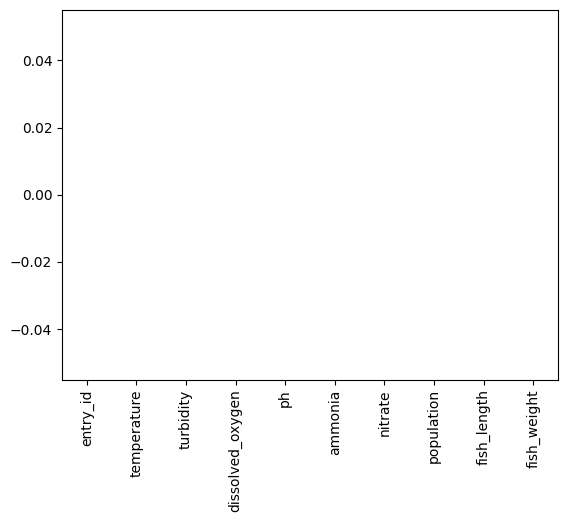

In [12]:
pond1.isna().sum().plot.bar()

In [13]:
pond1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83126 entries, 2021-06-19 00:00:05 to 2021-10-13 04:14:22
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   entry_id          83126 non-null  int64  
 1   temperature       83126 non-null  float64
 2   turbidity         83126 non-null  int64  
 3   dissolved_oxygen  83126 non-null  float64
 4   ph                83126 non-null  float64
 5   ammonia           83126 non-null  float64
 6   nitrate           83126 non-null  int64  
 7   population        83126 non-null  int64  
 8   fish_length       83126 non-null  float64
 9   fish_weight       83126 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 7.0 MB


In [14]:
pond1.head()

,entry_id,temperature,turbidity,dissolved_oxygen,ph,ammonia,nitrate,population,fish_length,fish_weight
datetime,,,,,,,,,,
2021-06-19 00:00:05,1889,24.8750,100,4.505,8.43365,0.45842,193,50,7.11,2.91
2021-06-19 00:01:02,1890,24.9375,100,6.601,8.43818,0.45842,194,50,7.11,2.91
2021-06-19 00:01:22,1891,24.8750,100,15.797,8.42457,0.45842,192,50,7.11,2.91
2021-06-19 00:01:44,1892,24.9375,100,5.046,8.43365,0.45842,193,50,7.11,2.91
2021-06-19 00:02:07,1893,24.9375,100,38.407,8.40641,0.45842,192,50,7.11,2.91


# Exploratory Data Analysis (EDA)

In [15]:
pond1.describe()

,entry_id,temperature,turbidity,dissolved_oxygen,ph,ammonia,nitrate,population,fish_length,fish_weight
count,83126.000000,83126.000000,83126.000000,83126.000000,83126.000000,8.312600e+04,83126.000000,83126.0,83126.000000,83126.000000
mean,84018.144516,24.573376,87.490160,12.390251,7.518329,2.030817e+08,458.294408,50.0,16.414686,44.568470
std,53579.484245,0.861532,25.859375,12.518253,0.534787,7.863770e+09,338.313206,0.0,5.272180,33.215091
min,1889.000000,-127.000000,1.000000,0.007000,-0.586270,6.770000e-03,45.000000,50.0,7.110000,2.910000
25%,24902.250000,24.125000,91.000000,3.440000,7.153520,4.584200e-01,146.000000,50.0,11.790000,14.190000
50%,103478.500000,24.562500,100.000000,7.133000,7.357790,6.139700e-01,347.000000,50.0,18.080000,54.700000
75%,131074.750000,24.937500,100.000000,15.819000,7.838980,1.565161e+01,823.000000,50.0,21.000000,67.520000
max,247405.000000,27.750000,100.000000,41.046000,8.551670,4.270000e+11,1936.000000,50.0,33.450000,318.640000


### Define variables

In [16]:
# without population since its a contant value
vars = ['temperature', 'turbidity', 'dissolved_oxygen', 'ph', 'ammonia', 'fish_length', 'fish_weight','nitrate']

### Data Dristribution and Trends

#### Histrograms

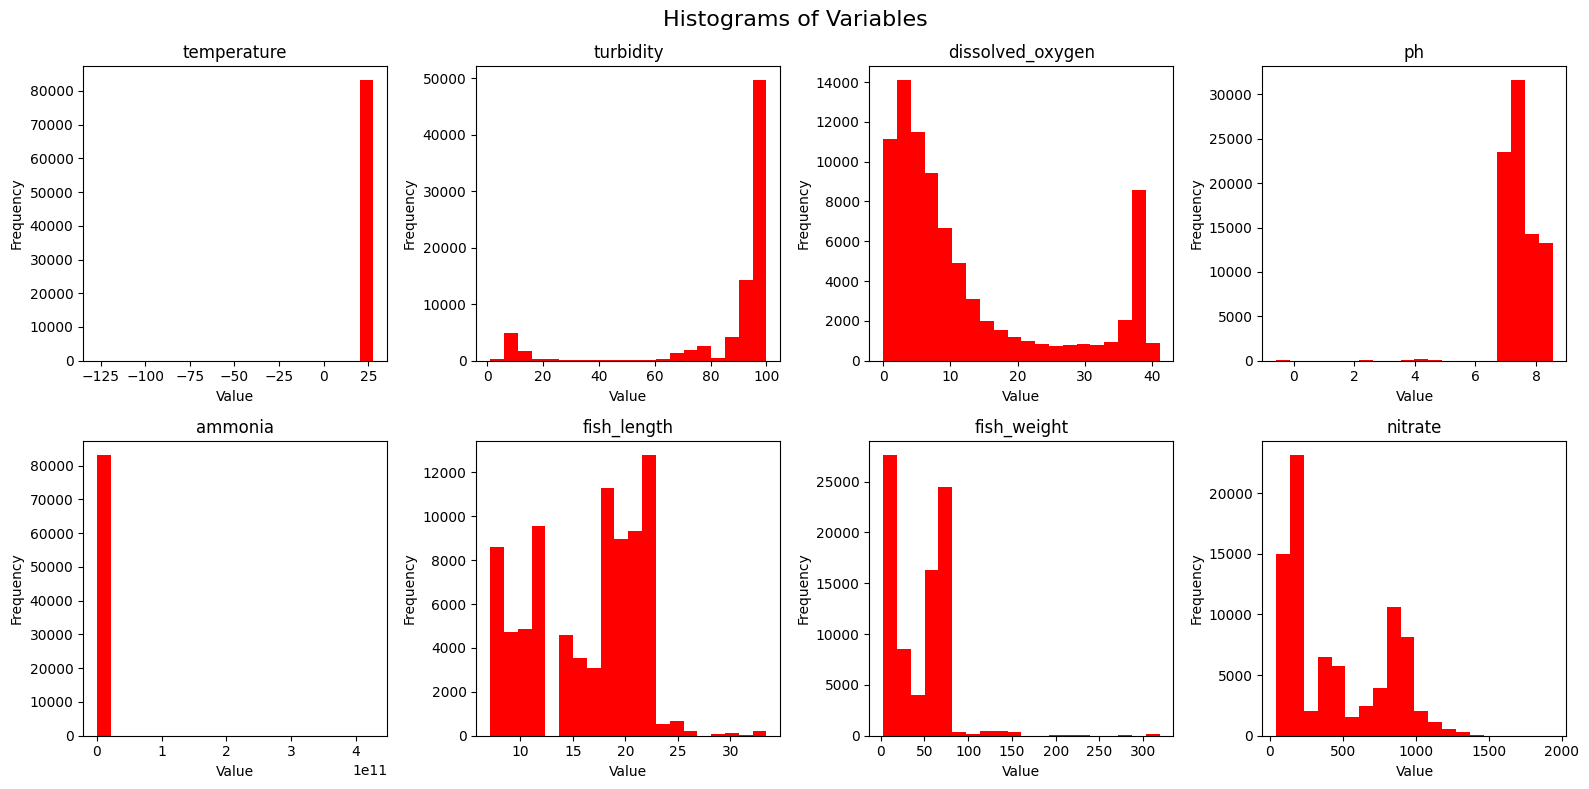

In [17]:
# set grid and size
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
fig.suptitle("Histograms of Variables", fontsize=16)

# flatten axes for easy iteration
axes = axes.flatten()

# create each histogram
for i, col in enumerate(vars):
    axes[i].hist(pond1[col], bins=20, color='red')
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# adjusts spacing
plt.tight_layout()
plt.show()

#### Visual Representation

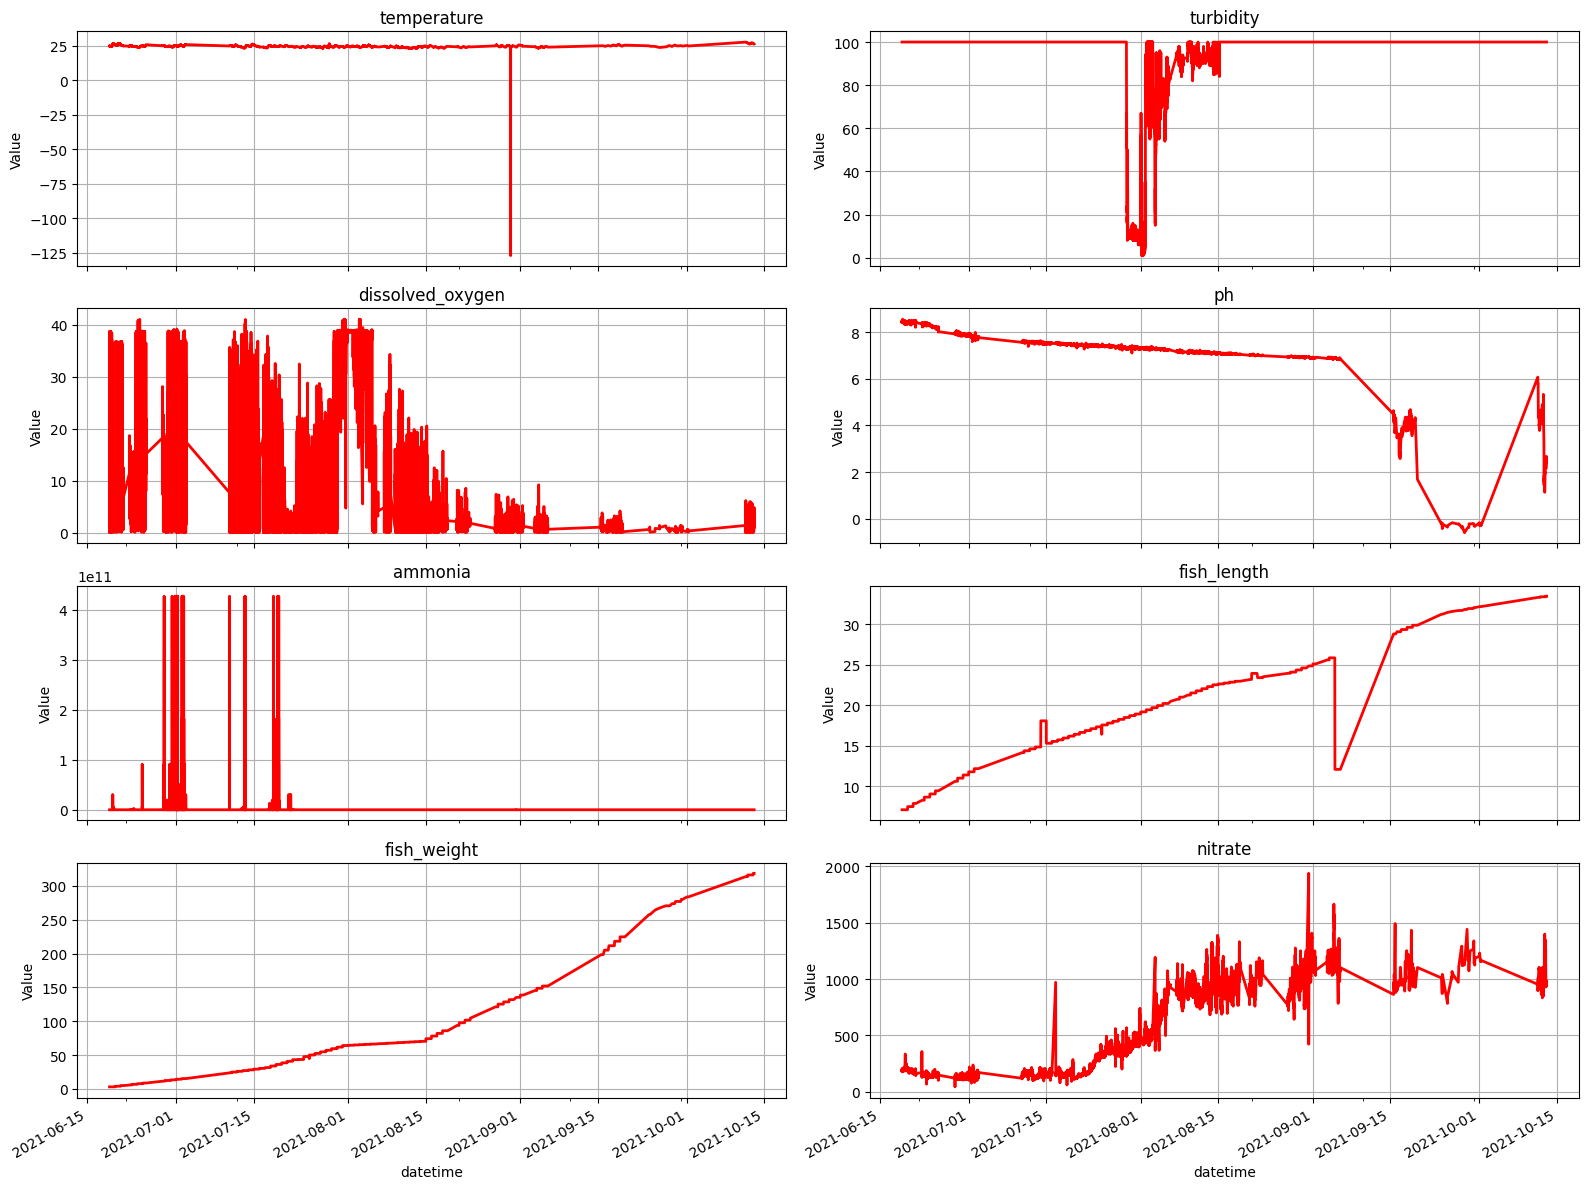

In [18]:
# set grid and size
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 12), sharex=True)

# flatten axes for easy iteration
axes = axes.flatten()

# create subplots for each variables
for i, col in enumerate(vars):
    pond1[col].plot(ax=axes[i], title=col, linewidth=2, color='red')
    axes[i].set_ylabel("Value")
    axes[i].grid(True)  # add grid for better readability

# remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# adjusts spacing
plt.tight_layout()
plt.show()

## Handle Outliers

In [19]:
# # remove missing values
# n_before = pond1.shape[0] # number of rows before dropping outliers

# # calculat quartiles
# Q1 = pond1.quantile(0.25) # 25th percentile
# Q3 = pond1.quantile(0.75) # 75th percentile
# IQR = Q3 - Q1 # interquartile range

# # define the outlier upper/lower bounds
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # filter the df to remove outliers
# pond1 = pond1[
#     ~((pond1 < lower_bound) | (pond1 > upper_bound)).any(axis=1) # if within the bounds
# ]

# n_after = pond1.shape[0] # Get the number of rows after dropping outliers
# print(f"Number of rows deleted: {n_before - n_after}")

In [20]:
# calculate quartiles
Q1 = pond1.quantile(0.25, axis=0)  # 25th percentile
Q3 = pond1.quantile(0.75, axis=0)  # 75th percentile
IQR = Q3 - Q1  # interquartile range

# define the outlier upper/lower bounds
t = 1.5 # thresholds
lower_bound = Q1 - t * IQR
upper_bound = Q3 + t * IQR

# identify outliers
outliers = (pond1 < lower_bound) | (pond1 > upper_bound)

# replace outliers with the previous valid value in each column
pond1_filtered = pond1.copy()
pond1_filtered[outliers] = np.nan  # temporarily set outliers as NaN
pond1_filtered.interpolate(method='linear', inplace=True) # estimates missing values by interpolating between known values

print("Outliers replaced by interpolating between known values.")

Outliers replaced by interpolating between known values.


In [21]:
pond1_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83126 entries, 2021-06-19 00:00:05 to 2021-10-13 04:14:22
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   entry_id          83126 non-null  int64  
 1   temperature       83126 non-null  float64
 2   turbidity         83126 non-null  float64
 3   dissolved_oxygen  83126 non-null  float64
 4   ph                83126 non-null  float64
 5   ammonia           83126 non-null  float64
 6   nitrate           83126 non-null  float64
 7   population        83126 non-null  int64  
 8   fish_length       83126 non-null  float64
 9   fish_weight       83126 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 7.0 MB


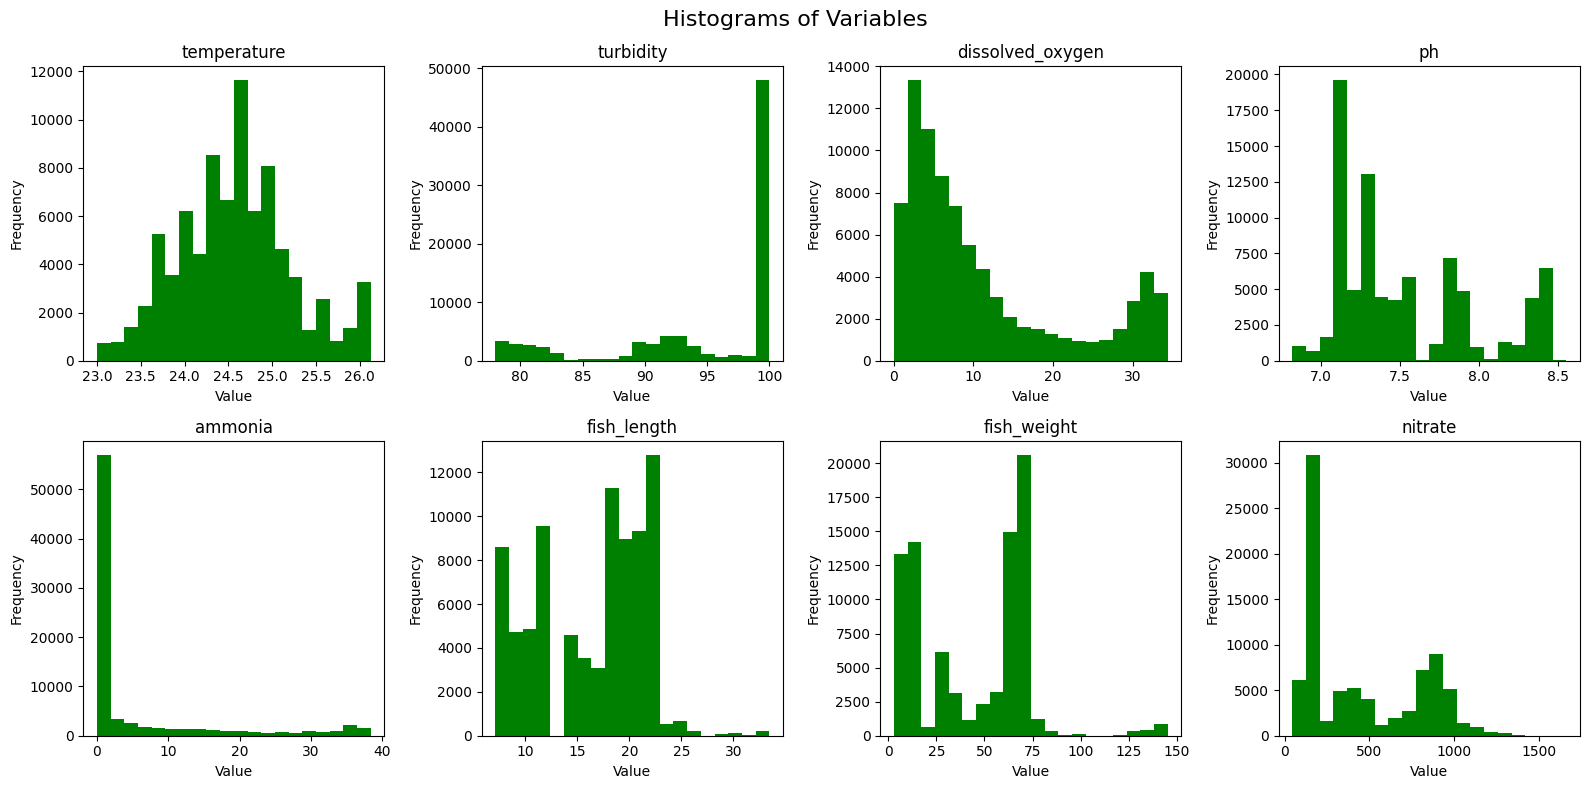

In [22]:
# set grid and size
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
fig.suptitle("Histograms of Variables", fontsize=16)

# flatten axes for easy iteration
axes = axes.flatten()

# create each histogram
for i, col in enumerate(vars):
    axes[i].hist(pond1_filtered[col], bins=20,  color='green')
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# adjusts spacing
plt.tight_layout()
plt.show()

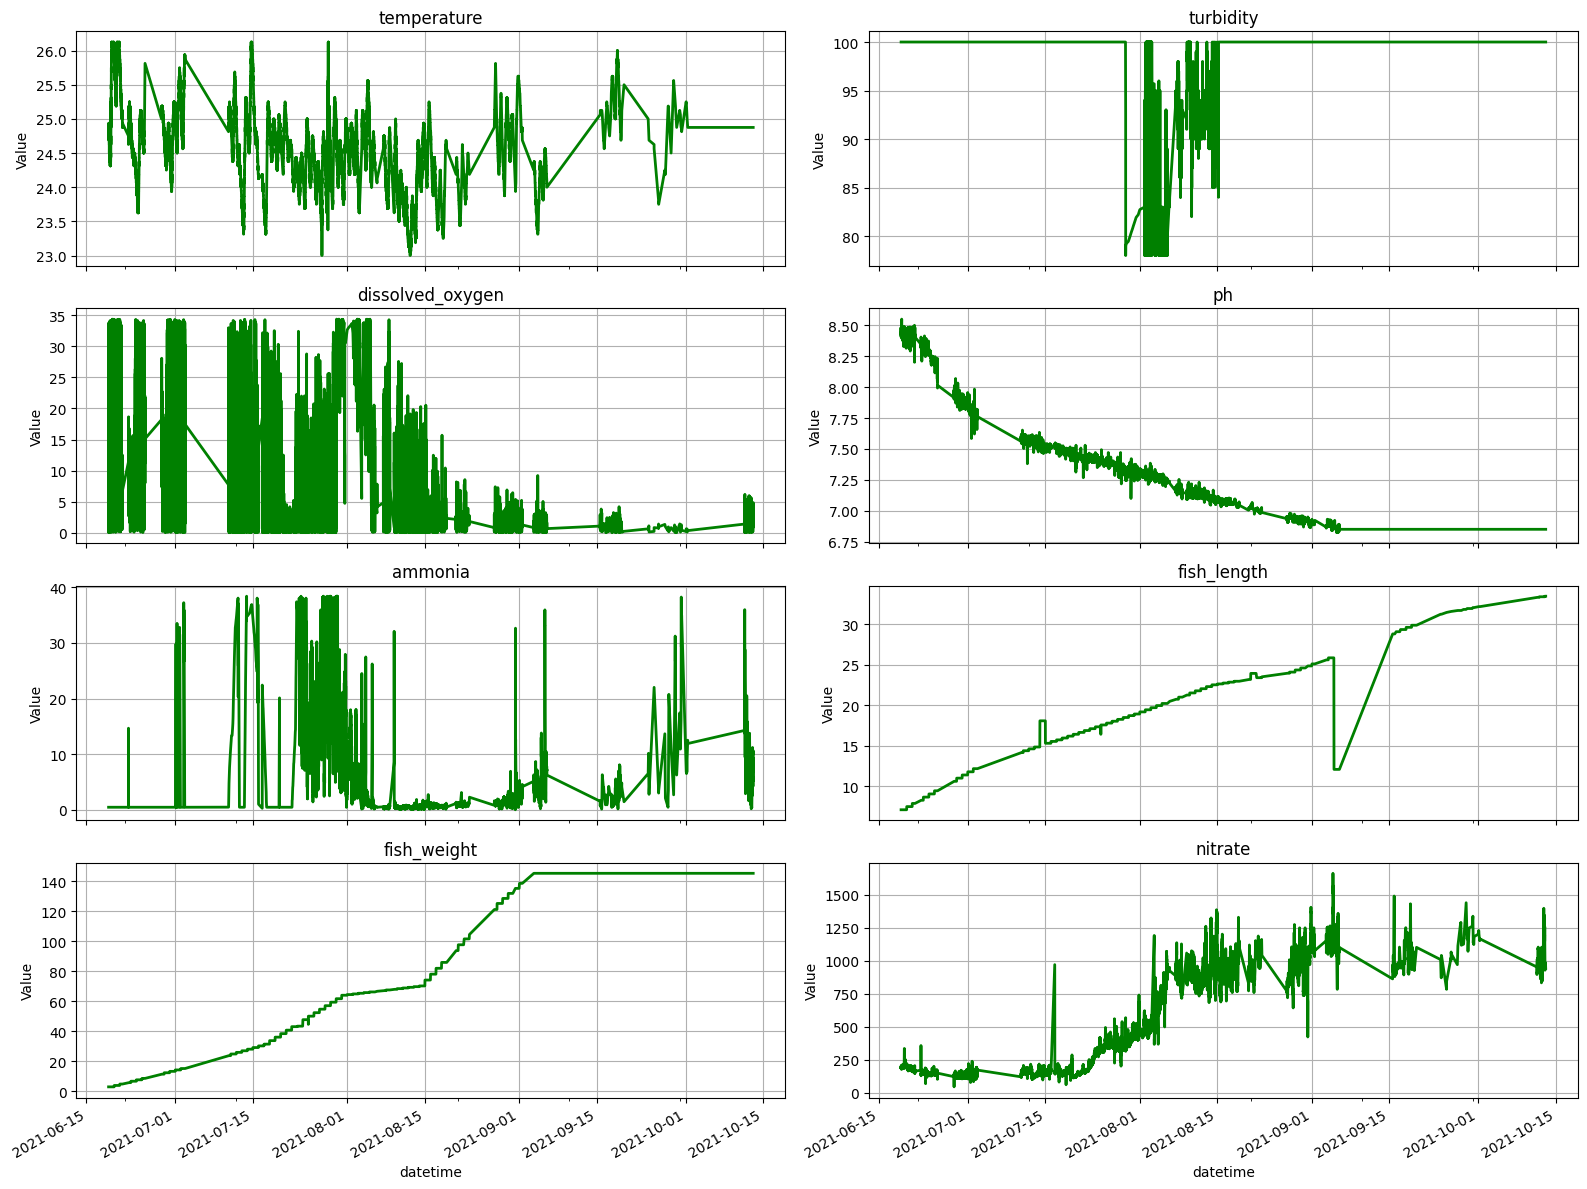

In [23]:
# set grid and size
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 12), sharex=True)

# flatten axes for easy iteration
axes = axes.flatten()

# create subplots for each variables
for i, col in enumerate(vars):
    pond1_filtered[col].plot(ax=axes[i], title=col, linewidth=2, color='green')
    axes[i].set_ylabel("Value")
    axes[i].grid(True)  # add grid for better readability

# remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# adjusts spacing
plt.tight_layout()
plt.show()

### Monthly Average

In [24]:
# group by 'datetime' with monthly frequency
pond1_monthly_avg = pond1_filtered.groupby(pd.Grouper(freq='M'))[vars].mean()
pond1_monthly_avg.head()

,temperature,turbidity,dissolved_oxygen,ph,ammonia,fish_length,fish_weight,nitrate
datetime,,,,,,,,
2021-06-30,24.983124,100.000000,9.484928,8.193054,0.460505,9.082526,7.664294,155.724018
2021-07-31,24.679681,95.492025,12.799360,7.513028,14.255660,15.858532,37.591927,245.305713
2021-08-31,24.186429,90.959051,10.439719,7.156489,1.438312,21.327552,70.045617,829.625175
2021-09-30,24.495140,100.000000,1.230838,6.863223,5.003797,23.662442,144.758165,1135.477449
2021-10-31,24.880939,100.000000,1.578326,6.849370,7.855854,33.333122,145.300000,1012.194570


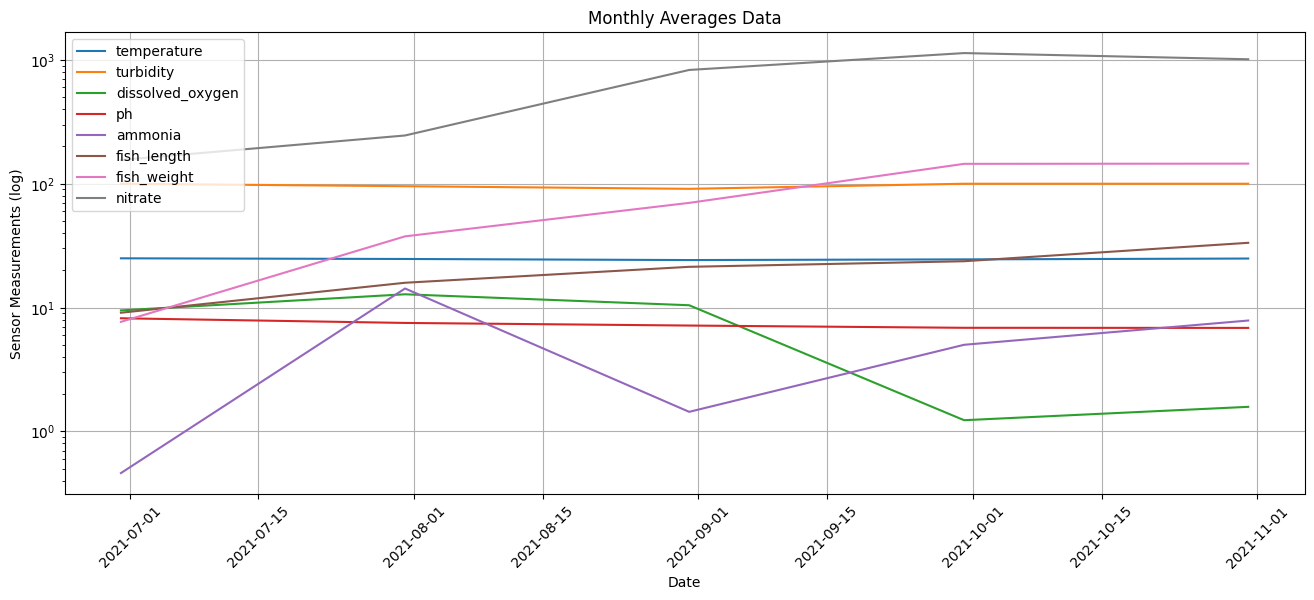

In [25]:
# plot each variable
plt.figure(figsize=(16, 6))
for column in vars:
    plt.plot(pond1_monthly_avg.index,  # months
             pond1_monthly_avg[column],  # monthly average
             label=column)

plt.title('Monthly Averages Data')
plt.xlabel('Date')
plt.ylabel('Sensor Measurements (log)')
plt.yscale('log')  # log scale for readability
plt.legend()
plt.xticks(rotation=45)  # for better visibility
plt.grid(True)
plt.show()

### Data Correlation

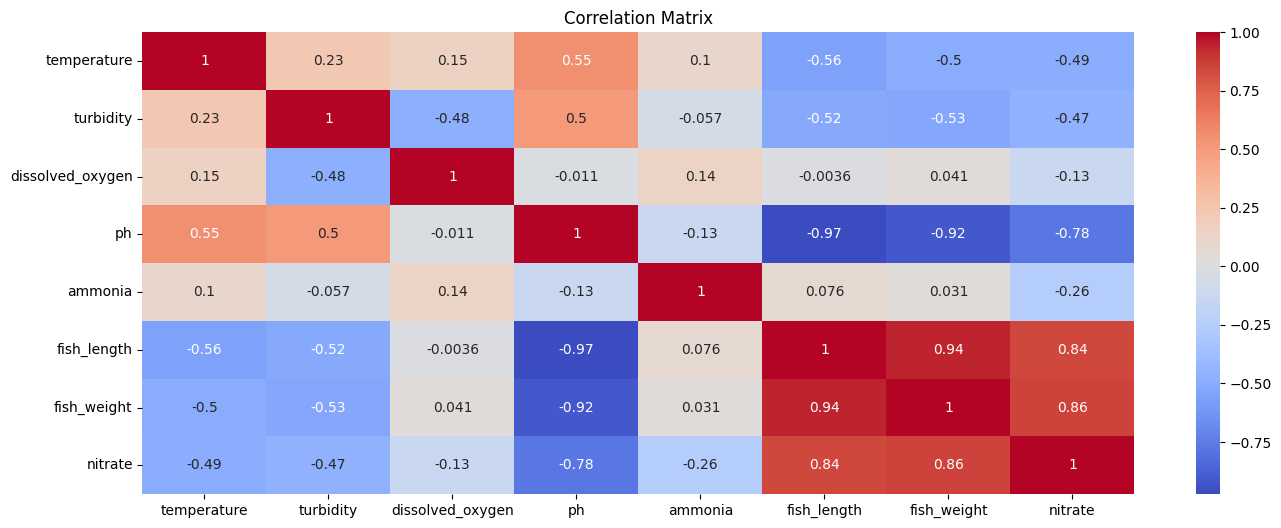

In [26]:
# compute correlation matrix
corr_matrix = pond1_filtered[vars].corr()

# display heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Feature Selection

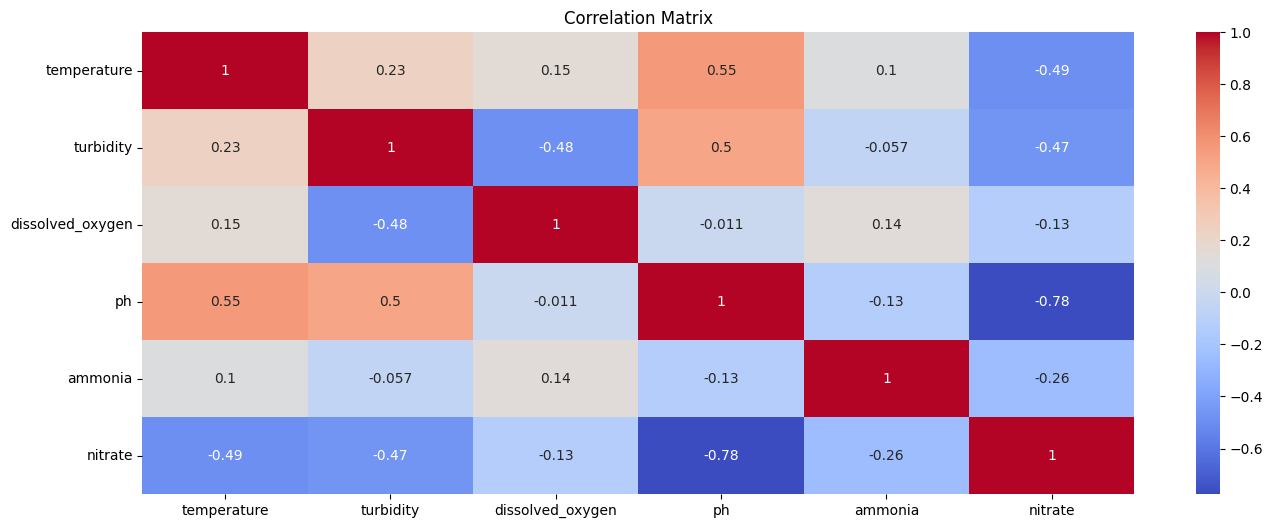

In [27]:
features_for_prediction = ['temperature', 'turbidity', 'dissolved_oxygen', 'ph', 'ammonia','nitrate']
corr_matrix = pond1_filtered[features_for_prediction].corr()

# display heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

            PC1       PC2
0     -3.455919 -0.761627
1     -3.481534 -0.589280
2     -3.430714  0.039299
3     -3.480860 -0.698752
4     -3.457359 -0.739224
...         ...       ...
83121  4.971406 -1.200313
83122  5.017419 -1.248802
83123  4.992534 -1.089410
83124  4.977672 -0.698144
83125  4.970925 -0.972577

[83126 rows x 2 columns]
Explained Variance Ratio: [0.59075349 0.16504789]


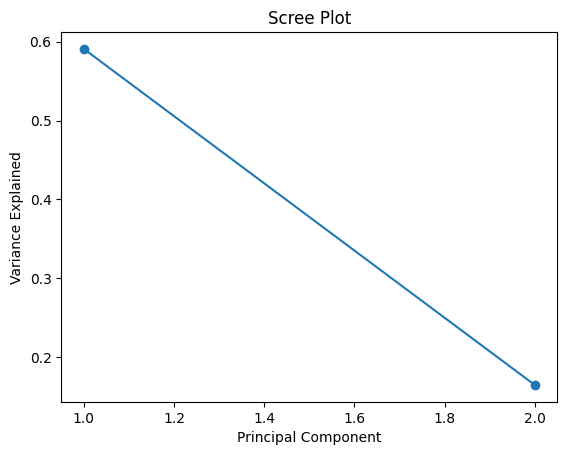

In [28]:
scaler = StandardScaler()
pond_scaled = scaler.fit_transform(pond1_filtered)

# 2. Applying PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions
principal_components = pca.fit_transform(pond_scaled)

# 3. Convert to DataFrame
df_pca = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
print(df_pca)

# 4. Explained Variance Ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# 5. Scree Plot (to decide optimal components)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Scree Plot')
plt.show()

#### Feature Selection
* There are 8 features in the original data set
* For predicting Fish Length,  Correlation Matrix shows  Fish Weight, Ammonia, Nitrate, Temperature and PH has strong correlations with  Fish length.  Since Fish Weight is the observed variable, we can ignore .
* For time series, prediction we can use Fish length/Fish Weight but these are not IOT data . We can control nitrate value and  predict it for the future

# Machine Learning Models

In [29]:
predicted_feature='ph'

## Traditional

In [30]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
# from pmdarima import auto_arima

def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    if result[1] > 0.05:
        print("Series is NOT stationary.")
    else:
        print("Series is stationary.")

adf_test(pond1_filtered[predicted_feature])


pond1_filtered[f'{predicted_feature}_Diff'] = pond1_filtered[predicted_feature].diff()

pond1_filtered[f'{predicted_feature}_Diff'].dropna(inplace=True)


# auto_arima(pond1_filtered[predicted_feature], seasonal=False, trace=True)

ADF Statistic: -1.4531
p-value: 0.5566
Series is NOT stationary.


In [31]:
diff_series=pond1_filtered[f'{predicted_feature}_Diff'].dropna()
adf_test(diff_series)

ADF Statistic: -70.9611
p-value: 0.0000
Series is stationary.


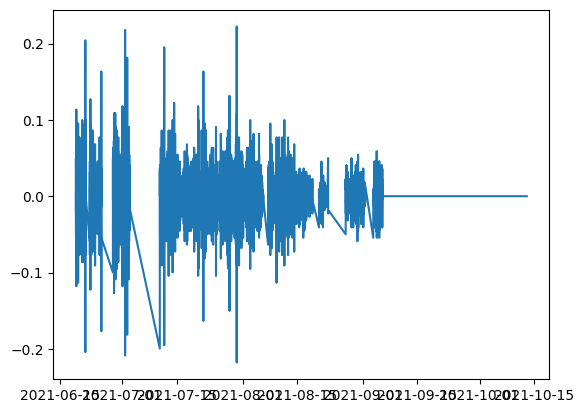

In [32]:
plt.plot(pond1_filtered[f'{predicted_feature}_Diff'])

In [33]:

train_size = int(len(diff_series) * 0.8)
train, test = diff_series.iloc[:train_size], diff_series.iloc[train_size:]

print(f"Train Size: {len(train)}, Test Size: {len(test)}")


Train Size: 66500, Test Size: 16625


In [34]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train, order=(2, 1, 2))  # Example order (p,d,q)
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


KeyboardInterrupt: 

In [ ]:
test.values

In [ ]:
# 5. Forecast Future Values
forecast_steps = 12
forecast = model_fit.forecast(steps=forecast_steps)

# 6. Plot Original Data and Forecast
plt.figure(figsize=(10,5))
plt.plot(diff_series.index, pond1_filtered['predicted_feature'], label='Original Data')
plt.plot(pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='M')[1:], forecast, label='Forecast', color='red')
plt.legend()
plt.show()

## Deep Learning

In [40]:
# Feature Selection & Engineering
print("Starting feature selection and engineering...")
inputs = ['fish_length', 'temperature', 'nitrate', 'dissolved_oxygen', 'ammonia']
target = 'fish_weight'

Starting feature selection and engineering...


In [41]:
# Rolling statistics for highly variable features from sensors
window_sizes = [6, 12, 24]
for window in window_sizes:
    pond1_filtered[f'do_rolling_mean_{window}h'] = pond1_filtered['dissolved_oxygen'].rolling(window).mean()
    pond1_filtered[f'ammonia_rolling_mean_{window}h'] = pond1_filtered['ammonia'].rolling(window).mean()
    inputs.extend([f'do_rolling_mean_{window}h', f'ammonia_rolling_mean_{window}h'])

# Add interaction terms
pond1_filtered['temp_do_interaction'] = pond1_filtered['temperature'] * pond1_filtered['dissolved_oxygen']
inputs.append('temp_do_interaction')

# Fill NaN values from rolling calculations
pond1_filtered.fillna(method='bfill', inplace=True)
pond1_filtered.fillna(method='ffill', inplace=True)

# Apply log transformation to handle skewness
pond1_filtered['nitrate'] = np.log1p(pond1_filtered['nitrate'])
pond1_filtered['fish_weight'] = np.log1p(pond1_filtered['fish_weight'])
pond1_filtered['ammonia'] = np.log1p(pond1_filtered['ammonia'])

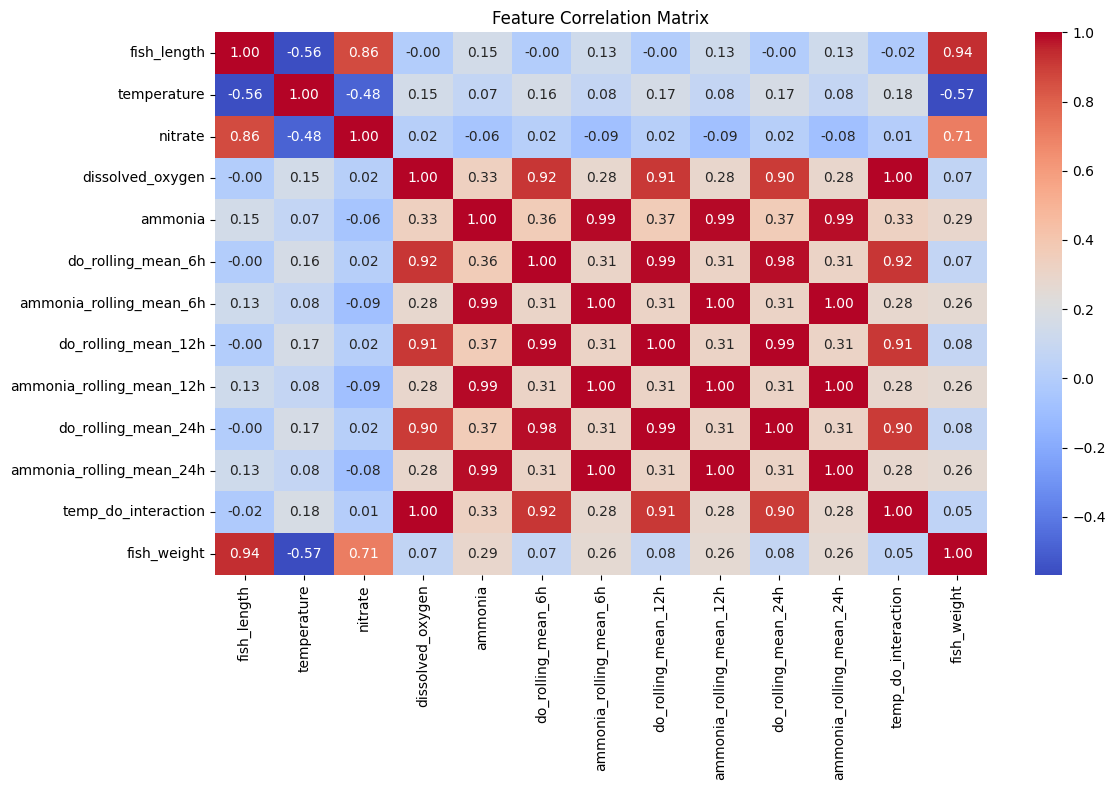

In [42]:
# Visualize new correlation matrix
plt.figure(figsize=(12, 8))
corr = pond1_filtered[inputs + [target]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [43]:
# Train-Test Split (Chronological 80/20)
seq_length = 40
train_size = int(0.8 * (len(pond1_filtered) - seq_length))

train_df = pond1_filtered.iloc[:train_size].copy()
test_df = pond1_filtered.iloc[train_size:].copy()

In [44]:
# Feature Scaling using RobustScaler
scaler_inputs = RobustScaler()
scaler_target = RobustScaler()

train_df_scaled = train_df.copy()
test_df_scaled = test_df.copy()

train_df_scaled[inputs] = scaler_inputs.fit_transform(train_df[inputs])
test_df_scaled[inputs] = scaler_inputs.transform(test_df[inputs])

train_df_scaled[target] = scaler_target.fit_transform(train_df[[target]])
test_df_scaled[target] = scaler_target.transform(test_df[[target]])

In [45]:
# Create Sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :-1])
        y.append(data[i + seq_length, -1])
    return np.array(X), np.array(y)

In [46]:
# Create sequences for training and testing
X_train, y_train = create_sequences(train_df_scaled[inputs + [target]].values, seq_length)
X_test, y_test = create_sequences(test_df_scaled[inputs + [target]].values, seq_length)

In [47]:
# LSTM Model Architecture
model = Sequential([
    LSTM(256, activation='tanh', return_sequences=True,
         kernel_regularizer=tf.keras.regularizers.l2(0.001),
         recurrent_regularizer=tf.keras.regularizers.l2(0.001),
         input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.4),

    LSTM(128, activation='tanh',
         kernel_regularizer=tf.keras.regularizers.l2(0.001),
         recurrent_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='huber', metrics=['mae'])
model.summary()

# Define callbacks for training efficiency
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 40, 256)             │         275,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 40, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 40, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 484,737 (1.85 MB)

 Trainable params: 483,841 (1.85 MB)

 Non-trainable params: 896 (3.50 KB)

In [49]:
# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
2076/2076 ━━━━━━━━━━━━━━━━━━━━ 449s 213ms/step - loss: 0.4892 - mae: 0.2455 - val_loss: 0.0491 - val_mae: 0.0892 - learning_rate: 0.0010
Epoch 2/30
2076/2076 ━━━━━━━━━━━━━━━━━━━━ 434s 209ms/step - loss: 0.0257 - mae: 0.0910 - val_loss: 0.0180 - val_mae: 0.0997 - learning_rate: 0.0010
Epoch 3/30
2076/2076 ━━━━━━━━━━━━━━━━━━━━ 427s 202ms/step - loss: 0.0147 - mae: 0.0862 - val_loss: 0.0291 - val_mae: 0.0608 - learning_rate: 0.0010
Epoch 4/30
2076/2076 ━━━━━━━━━━━━━━━━━━━━ 455s 208ms/step - loss: 0.0138 - mae: 0.0822 - val_loss: 0.0206 - val_mae: 0.0700 - learning_rate: 0.0010
Epoch 5/30
2076/2076 ━━━━━━━━━━━━━━━━━━━━ 446s 210ms/step - loss: 0.0119 - mae: 0.0745 - val_loss: 0.0224 - val_mae: 0.0902 - learning_rate: 0.0010
Epoch 6/30
1290/2076 ━━━━━━━━━━━━━━━━━━━━ 2:28 189ms/step - loss: 0.0090 - mae: 0.0676

KeyboardInterrupt: 

# Model Evaluation

In [50]:
# Evaluate model and print results
y_pred = model.predict(X_test)

# Inverse transform predictions and true values
y_pred_inv = scaler_target.inverse_transform(y_pred)
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Compute metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print("\nModel Performance:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

520/520 ━━━━━━━━━━━━━━━━━━━━ 33s 62ms/step

Model Performance:
MSE: 0.0006
RMSE: 0.0250
R²: -2.3510


NameError: name 'history' is not defined

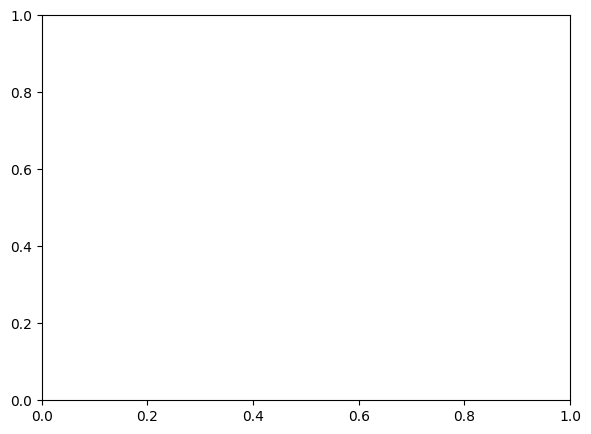

In [51]:
# Show visualizations
plt.figure(figsize=(15, 5))

# Plot 1: Training History
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot 2: Predictions vs Actual
plt.subplot(1, 2, 2)
plt.plot(y_test_inv, label='Actual Fish Weight', color='blue')
plt.plot(y_pred_inv, label='Predicted Fish Weight', color='red', alpha=0.7)
plt.title("Actual vs Predicted Fish Weight")
plt.xlabel("Sample")
plt.ylabel("Fish Weight")
plt.legend()

plt.tight_layout()
plt.show()

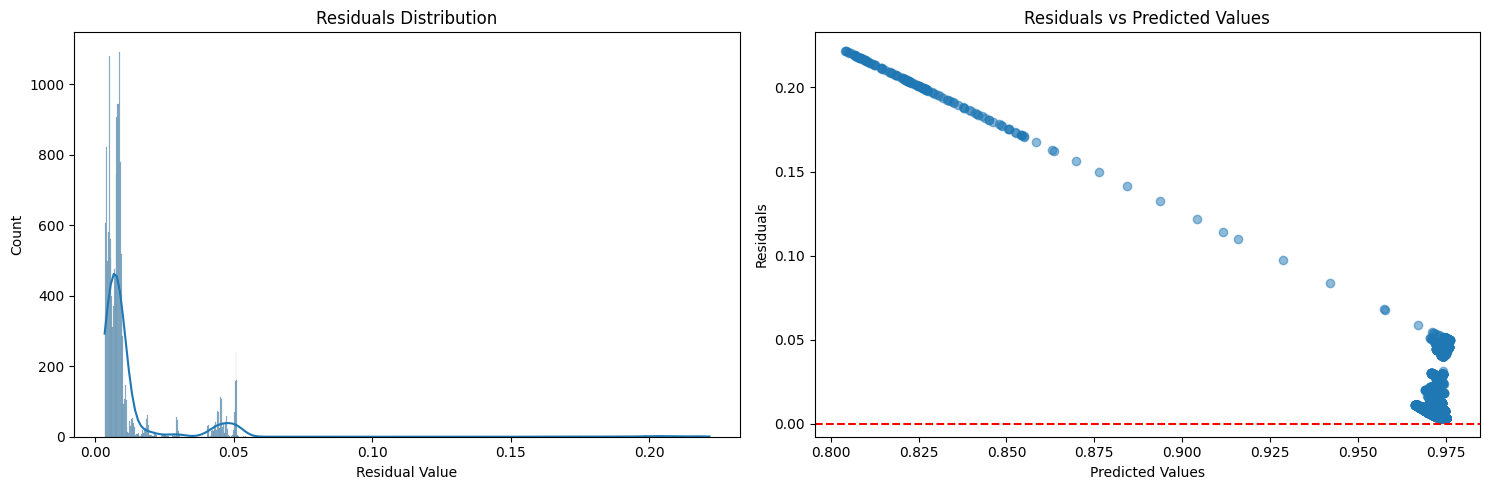

In [52]:
# Residual Analysis
residuals = y_test_inv.reshape(-1) - y_pred_inv.reshape(-1)

plt.figure(figsize=(15, 5))

# Plot 1: Residuals Distribution
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residual Value')

# Plot 2: Residuals vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(y_pred_inv, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

# Model Deployment

# Data Export


----------------
$^{1}$ Ogbuokiri, B. (2021). Sensor-based aquaponics fish pond datasets. Kaggle. https://www.kaggle.com/datasets/ogbuokiriblessing/sensor-based-aquaponics-fish-pond-datasets